In [154]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
import pylustrator
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore", RuntimeWarning)
ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
save_path_without_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results.csv'))
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

In [155]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, scale=1, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 # DOUBLE CHECK
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

In [156]:
def add_hull(master_df, rEtaKsstats_dict, GROUP='group', debug=False):

    master_df_copy = master_df.copy()
    master_df_copy = master_df.set_index(GROUP)
    groups = master_df_copy.index
    master_df_copy["hull"] = ""

    for group in groups:
        if master_df_copy.loc[group, "total_samples"] < 10:
            master_df_copy.loc[group, "hull"] = np.nan
           
        else:
            drop_keys =list(rEtaKsstats_dict[group].keys())[-3:]
            if debug:
                print(drop_keys)
            pre_optimization = pd.DataFrame(rEtaKsstats_dict[group]).drop(drop_keys, axis = 1 )
            optimization = pd.DataFrame(rEtaKsstats_dict[group])[drop_keys]
            optimization = optimization.rename(columns = {"r_optimize": "r", "eta_optimize": "eta", drop_keys[-1]: "ksstat"})
            optimization = optimization.dropna()
            full_df = pre_optimization.merge(optimization, on=["r", "eta"], how="outer")
            full_df = full_df.set_index(["r", "eta"])
            full_df["ksstat"] = full_df.min(axis=1)
            full_df = full_df.reset_index()
            full_df = full_df[["r", "eta", "ksstat"]]
            full_df["1/beta"] = full_df["r"]/(full_df["eta"] + 1.5)
            full_df["log_beta"] = np.log10((full_df["eta"] + 1.5) / full_df["r"])
            MULT = 1.2
            cutoff = max(min(full_df["ksstat"]) * MULT, 0.01)
            filtered_df = full_df[full_df["ksstat"] < cutoff]
            points = np.column_stack((filtered_df["r"], filtered_df["1/beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            #points = np.column_stack((np.log10(filtered_df["r"]), filtered_df["log_beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            if len(points) < 3:
                hull=np.nan
                master_df_copy.loc[group, "intersect_roi"] = -1
            else:
                hull = ConvexHull(points)

                #x_vals = np.logspace(0, 20, 1000)
                #eta_vals = 1.5 + np.zeros_like(x_vals)
                #roi = (eta_vals) / x_vals
                
                #line_points = np.column_stack((x_vals, roi))
                #line_points = np.column_stack((np.log10(x_vals), np.log10(roi)))

                #intersect_roi = int(np.any(in_hull(line_points, hull)))
                if np.any(filtered_df["eta"] > 0) and np.any(filtered_df["eta"] < 0):
                    intersect_roi = 1
                else:
                    intersect_roi = 0
                master_df_copy.loc[group, "intersect_roi"] = intersect_roi
            master_df_copy.loc[group, "hull"] = hull

    return master_df_copy.reset_index()

In [157]:
def add_hull_and_kurt(master_df, rEtaKsstats_dict, GROUP='group', debug=False):

    master_df_copy = master_df.copy()
    master_df_copy = master_df.set_index(GROUP)
    groups = master_df_copy.index
    master_df_copy["hull"] = ""

    for group in groups:
        obs_kurt, kurt_lower, kurt_upper = master_df_copy.loc[group, "obs_kurt"], master_df_copy.loc[group, "kurt_lower"], master_df_copy.loc[group, "kurt_upper"]
        best_scale = master_df_copy.loc[group, "best_scale"]

        if master_df_copy.loc[group, "total_samples"] < 10:
            master_df_copy.loc[group, "hull"] = np.nan
        else:
            drop_keys =list(rEtaKsstats_dict[group].keys())[-3:]
            if debug:
                print(drop_keys)
            pre_optimization = pd.DataFrame(rEtaKsstats_dict[group]).drop(drop_keys, axis = 1 )
            optimization = pd.DataFrame(rEtaKsstats_dict[group])[drop_keys]
            optimization = optimization.rename(columns = {"r_optimize": "r", "eta_optimize": "eta", drop_keys[-1]: "ksstat"})
            optimization = optimization.dropna()
            full_df = pre_optimization.merge(optimization, on=["r", "eta"], how="outer")
            full_df['kurt'] = full_df.apply(lambda row : kurtosis_prior(r=row['r'], eta=row['eta'], scale=best_scale), axis=1)
            full_df['pass_kurt'] = (full_df['kurt'] > kurt_lower) & (full_df['kurt'] < kurt_upper)
            
            full_df["beta"] = (full_df["eta"] + 1.5)/full_df["r"]
            full_df["1/beta"] = 1/full_df["beta"]
            kurt_df = full_df.copy()
            kurt_df["beta"] = (kurt_df["eta"] + 1.5)/kurt_df["r"]
            
            full_df = full_df.set_index(["r", "eta"])
            full_df["ksstat"] = full_df.min(axis=1)
            full_df = full_df.reset_index()
            full_df = full_df[["r", "eta", "ksstat", "1/beta"]]

            MULT = 1.2
            cutoff = max(min(full_df["ksstat"]) * MULT, 0.01)
            filtered_df = full_df[full_df["ksstat"] < cutoff]
            points = np.column_stack((filtered_df["r"], filtered_df["1/beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            if len(points) < 3:
                hull=np.nan
                master_df_copy.loc[group, "intersect_roi"] = -1
            else:
                hull = ConvexHull(points)

                if np.any(filtered_df["eta"] > 0) and np.any(filtered_df["eta"] < 0):
                    intersect_roi = 1
                else:
                    intersect_roi = 0
                    
                master_df_copy.loc[group, "intersect_roi"] = intersect_roi

            pass_kurt_anywhere = np.sum(kurt_df['pass_kurt'] > 0)
            if pass_kurt_anywhere > 3:
                temp = kurt_df[kurt_df['pass_kurt'] == 1]
                kurt_points = np.column_stack((temp["r"], temp["beta"])) + stats.norm.rvs(size=(len(temp), 2)) * 0.001
                master_df_copy.loc[group, "hull_kurt"] = ConvexHull(kurt_points)
            else:
                master_df_copy.loc[group, "hull_kurt"] = np.nan

            
            master_df_copy.loc[group, "hull"] = hull
            master_df_copy.loc[group, "num_pass_kurt_anywhere"] = pass_kurt_anywhere
            master_df_copy.loc[group, "pass_kurt_anywhere"] = int(pass_kurt_anywhere > 0)
            master_df_copy.loc[group, "num_pass_kurt_intersect_hull"] = np.sum((kurt_df['pass_kurt'] == 1) & (kurt_df['ksstat'] < cutoff))
            master_df_copy.loc[group, "pass_kurt_intersect_hull"] = int(master_df_copy.loc[group, "num_pass_kurt_intersect_hull"] > 0)

    return master_df_copy.reset_index()

def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

In [158]:
all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_paths

['/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/scaleTesting/wavelet/full/gray/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/scaleTesting/wavelet/full/laplace/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/experiments/scaleTesting/_/samplePrior/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ada/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/aad/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ddd/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/daa/CSVs/master_

In [159]:
relevant_cols = [
        'group', 'dataset', 'subset', 'transform', 'orientation', 'channel', 'dataset_type', 
        'obs_var', 'var_lower', 'var_upper', 
        'total_samples', 'initial_r', 'initial_eta',  'best_r', 'best_eta', 'best_scale',
        'kstest_stat_initial', 'kstest_stat_cutoff_0.05', 'kstest_stat_best',
        'obs_kurt', 'kurt_lower', 'kurt_upper', 'num_pass_kurt_anywhere', 'pass_kurt_anywhere', 'num_pass_kurt_intersect_hull', 'pass_kurt_intersect_hull', 'hull', 'hull_kurt',
        'param_gaussian', 'kstest_stat_gaussian', 'kstest_pval_gaussian', 
        'param_laplace', 'kstest_stat_laplace', 'kstest_pval_laplace', 
        'param_t', 'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
        'github_plot', 'intersect_roi', 'hull_kurt']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

for i in tqdm(range(len(all_paths))):
    path = all_paths[i]
    if 'scaleTesting' in path:
        continue
    if path in all_paths[:4]: # just test agriVision fourier
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    elif parts[0] == 'results':
        parts = parts[2:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    elif "learned" in path:
        dataset, subset, transform, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df = master_df.rename(columns={'filter_group' : 'orientation'})
        master_df['channel'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]

    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything', 'standardTesting']:
        master_df['dataset_type'] = 'natural'
    elif dataset in ['standardTesting']:
        master_df['dataset_type'] = 'classical'

    GROUP = 'layer' if transform.split("-")[0] == 'wavelet' else ('band' if transform.split("-")[0] == 'fourier' else 'filter_idx')
    rEtaKsstatsDict = pd.read_pickle(path[:-18] + "cache" + os.sep + "rEtaKsstats_dict.pickle")
    
    master_df = add_hull_and_kurt(master_df, rEtaKsstatsDict)
    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)

main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['best_1/beta'] = 1/main_df['best_beta']
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)
main_df["best_prior"] = np.array(["GenGamma", "Gaussian", "Laplace", "Student-T", np.nan])[
                                np.nanargmin(np.array([main_df['kstest_stat_best'], 
                                                        main_df['kstest_stat_gaussian'], 
                                                        main_df['kstest_stat_laplace'], 
                                                        main_df['kstest_stat_t'], 
                                                        0.99*np.ones_like(main_df['kstest_stat_t'])]
                                                        ).T, axis=1)]

print("Main DF (before frequency):", main_df.shape)
frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True, how='left').reset_index()

print("Main DF (after frequency):", main_df.shape)
old_fail_cat_df_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs", 'result_categorization_sheet - combined_categories.csv')
old_fail_cat_df = pd.read_csv(old_fail_cat_df_path)
main_df = main_df.merge(old_fail_cat_df[['github_plot', 'failure_category', 'failure_type', 'which_ones']], on='github_plot', how='left')
print("Main DF (after result categorization):", main_df.shape)

  0%|          | 0/101 [00:00<?, ?it/s]/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_41322/1655223283.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<scipy.spatial._qhull.ConvexHull object at 0x7fc201c05c30>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  master_df_copy.loc[group, "hull_kurt"] = ConvexHull(kurt_points)
  9%|▉         | 9/101 [00:10<02:10,  1.42s/it]/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_41322/1655223283.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<scipy.spatial._qhull.ConvexHull object at 0x7fc1f2d41de0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  master_df_copy.loc[group, "hull_kurt"] = ConvexHull(kurt_points)
 10%|▉         | 10/101 [00:13<02:42,  1.78s/it]/var/folde

Main DF (before frequency): (1148, 45)
Main DF (after frequency): (1148, 46)
Main DF (after result categorization): (1148, 49)


In [160]:
master_df['hull']

0                                                  NaN
1    <scipy.spatial._qhull.ConvexHull object at 0x7...
2    <scipy.spatial._qhull.ConvexHull object at 0x7...
3    <scipy.spatial._qhull.ConvexHull object at 0x7...
4    <scipy.spatial._qhull.ConvexHull object at 0x7...
5    <scipy.spatial._qhull.ConvexHull object at 0x7...
6    <scipy.spatial._qhull.ConvexHull object at 0x7...
7    <scipy.spatial._qhull.ConvexHull object at 0x7...
8    <scipy.spatial._qhull.ConvexHull object at 0x7...
Name: hull, dtype: object

In [161]:
save_cols = ([
        'group', 'dataset', 'subset', 'transform', 'orientation', 'channel', 'dataset_type', 
        'obs_var', 'var_lower', 'var_upper', 
        'total_samples', 'initial_r', 'initial_eta',  'best_r', 'best_eta', 'best_scale',
        'kstest_stat_initial', 'kstest_stat_cutoff_0.05', 'kstest_stat_best',
        'obs_kurt', 'kurt_lower', 'kurt_upper', 'num_pass_kurt_anywhere', 'pass_kurt_anywhere', 'num_pass_kurt_intersect_hull', 'pass_kurt_intersect_hull', 'hull', 'hull_kurt',
        'param_gaussian', 'kstest_stat_gaussian', 'kstest_pval_gaussian', 
        'param_laplace', 'kstest_stat_laplace', 'kstest_pval_laplace', 
        'param_t', 'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
        'github_plot', 'intersect_roi', 'hull_kurt'] +
        ['total_samples', 'beat_all_priors', 'best_prior', 'failure_category', 'failure_type', 'which_ones']) # relevant_cols + more


In [162]:
main_df[save_cols].drop('hull', axis=1).to_csv(save_path_without_hull)
pd.to_pickle(main_df[save_cols], save_path_with_hull)

In [163]:
main_df[(main_df["dataset"] == "pastis") & (main_df["transform"] == "fourier")]

,dataset,subset,transform,group,orientation,channel,dataset_type,obs_var,var_lower,var_upper,...,intersect_roi,hull_kurt,best_beta,best_1/beta,beat_all_priors,best_prior,frequency,failure_category,failure_type,which_ones
619,pastis,full,fourier,2,NaN,green,remote sensing,10.047775,9.564716,10.551455,...,1.0,NaN,1.027027,0.973684,1,GenGamma,0.061242,actually_pass,pass,NaN
620,pastis,full,fourier,5,NaN,green,remote sensing,5.438562,5.180850,5.707798,...,1.0,NaN,1.197605,0.835000,1,GenGamma,0.078689,actually_pass,pass,NaN
621,pastis,full,fourier,8,NaN,green,remote sensing,3.018795,2.876773,3.165153,...,1.0,<scipy.spatial._qhull.ConvexHull object at 0x7...,3.333333,0.300000,1,GenGamma,0.098453,actually_pass,pass,NaN
622,pastis,full,fourier,11,NaN,green,remote sensing,1.740533,1.654402,1.830307,...,1.0,NaN,31.000000,0.032258,1,GenGamma,0.123565,actually_pass,pass,NaN
623,pastis,full,fourier,14,NaN,green,remote sensing,0.964945,0.918967,1.013377,...,1.0,<scipy.spatial._qhull.ConvexHull object at 0x7...,2.195122,0.455556,1,GenGamma,0.155566,actually_pass,pass,NaN
624,pastis,full,fourier,17,NaN,green,remote sensing,0.544932,0.518553,0.572532,...,1.0,<scipy.spatial._qhull.ConvexHull object at 0x7...,5.937500,0.168421,1,GenGamma,0.196261,actually_pass,pass,NaN
625,pastis,full,fourier,20,NaN,green,remote sensing,0.277552,0.264042,0.291775,...,1.0,NaN,13.750000,0.072727,1,GenGamma,0.247131,actually_pass,pass,NaN
626,pastis,full,fourier,23,NaN,green,remote sensing,0.131865,0.125401,0.138744,...,1.0,NaN,24.000000,0.041667,1,GenGamma,0.311794,actually_pass,pass,NaN
627,pastis,full,fourier,26,NaN,green,remote sensing,0.054975,0.051767,0.058932,...,1.0,NaN,51.500000,0.019417,1,GenGamma,0.392401,actually_pass,pass,NaN
628,pastis,full,fourier,29,NaN,green,remote sensing,0.019339,0.017729,0.021846,...,1.0,NaN,47.500000,0.021053,1,GenGamma,0.493909,practically_pass,pass,NaN


In [164]:
x_vals = np.logspace(0, 20, 1000)
eta_vals = 1.5 + np.zeros_like(x_vals)
roi = (eta_vals) / x_vals

line_points = np.column_stack((np.log10(x_vals), np.log10(roi)))


Intersect ROI: 1
Intersect ROI: 1
Intersect ROI: 1
Intersect ROI: 1


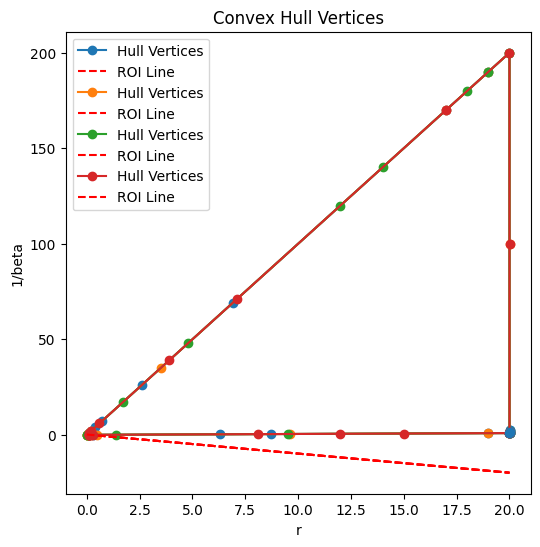

In [165]:
plt.figure(figsize=(6, 6))
idx = 670
for idx in [619, 630, 641, 652]:
    hull = main_df["hull"][idx]
    points = hull.points[hull.vertices]

    plt.plot(points[:, 0], points[:, 1], 'o-', label='Hull Vertices')
    plt.plot([points[0, 0], points[-1, 0]], [points[0, 1], points[-1, 1]], 'o-', color='C0')
    plt.plot(line_points[:, 0], line_points[:, 1], 'r--', label='ROI Line')
    intersect_roi = int(np.any(in_hull(line_points, hull)))
    print(f"Intersect ROI: {intersect_roi}")
plt.xlabel('r')
plt.ylabel('1/beta')
plt.title('Convex Hull Vertices')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [166]:
def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

In [167]:
def in_hull_list(p, hulls):
   return np.any([in_hull(p, hull) for hull in hulls], axis=0)

In [168]:
main_df = pd.read_pickle(save_path_with_hull)

In [169]:
main_df['intersect_roi'].value_counts()

intersect_roi
1.0    1130
Name: count, dtype: int64

In [170]:
all_paths

['/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/scaleTesting/wavelet/full/gray/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/scaleTesting/wavelet/full/laplace/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/experiments/scaleTesting/_/samplePrior/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ada/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/aad/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ddd/CSVs/master_df.csv',
 '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/daa/CSVs/master_

KeyError: 'best_beta'

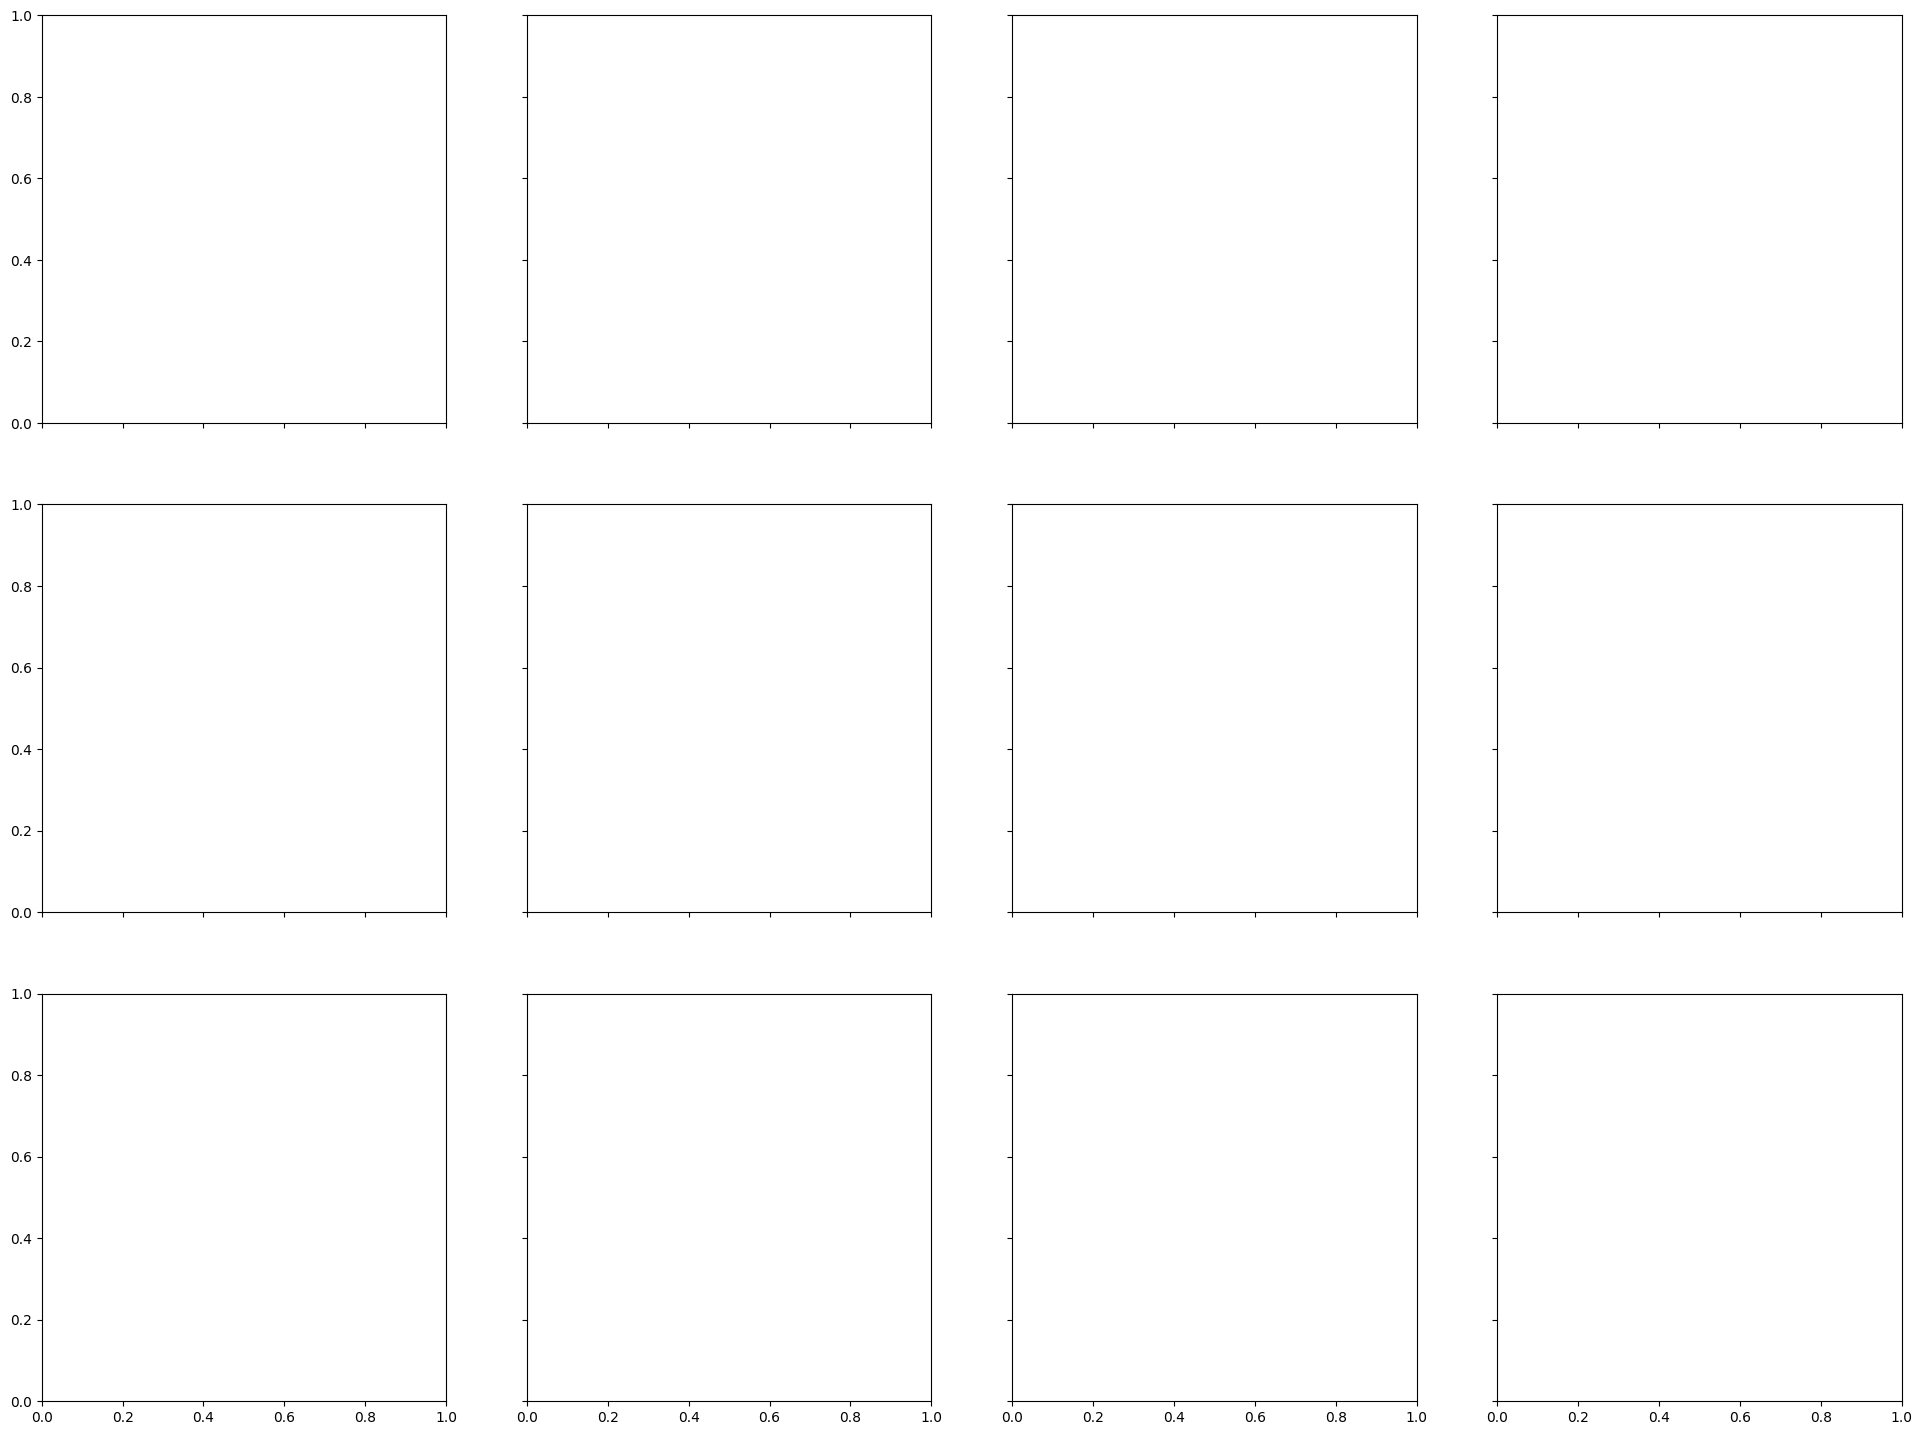

In [171]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("pastis", "full")] #[("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]
directions = ["fourier", "horizVert", "diagonal"]


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])
        df["best_1/beta"] = 1 / df["best_beta"]
        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}
        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        ax.set_title(f"{DATASET[0]}-{direction} \n {sum(temp_df['intersect_roi'])}/{len(temp_df)} hulls intersect ROI")

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df["best_1/beta"] = 1 / df["best_beta"]
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {sum(df['intersect_roi'])}/{len(df)} hulls intersect ROI")
    ax4.legend()

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
plt.tight_layout()
plt.show()

    
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_remote_sensing.png"), bbox_inches='tight', dpi=1000)